# Cell Migration: Simulation Study with Calibrated Model

In [1]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib.gridspec import GridSpec
from scipy.stats import circmean, circstd

from summary_stats import reduce_to_coordinates, compute_MSD_lags, turning_angle

In [2]:
gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # area of the cell  (\mu m^2)
}
obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
real_posterior = np.load(f'abc_results_real/posterior_samples_npe.npy')
real_posterior_median = np.median(real_posterior, axis=0)
print(real_posterior_median
      )

models_simulations = {
    'classic': 'cell_movement_v24.xml',
    'no_chemokine': 'cell_movement_v24-no-chemokine.xml',  # for simulation without chemokine
    'no_persistence': 'cell_movement_v24-no-persistent.xml',  # for simulation without persistent random walk
    'pulsing_chemokine': 'cell_movement_v24-puls_prefactor.xml',  # for simulation with pulsing chemokine
}

# defining the summary statistics function
min_sequence_length = 0
cells_in_population = 50
# note: this is different for inference
max_sequence_length = 1000
def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model,
                                            minimal_length=min_sequence_length,
                                            maximal_length=max_sequence_length,
                                            cut_region_of_interest=False
                                            )

    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((cells_in_population, max_sequence_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    
param_names = ['$g_{s}$', '$m_{s}$', '$m_{dm}$', '$c_{nr}$']
log_param_names = ['$\log_{10}(g_{s})$', '$\log_{10}(m_{s})$', '$\log_{10}(m_{dm})$', '$\log_{10}(c_{nr})$']

if os.path.exists('simulation_study_sims.pkl'):
    with open('simulation_study_sims.pkl', 'rb') as f:
        models_simulations = pickle.load(f)
else:
    for model_name, model_path in models_simulations.items():
        print(f'Simulating {model_name}')

        # define the model object
        model = morpheus_model.MorpheusModel(
            model_path, par_map=par_map, par_scale="log10",
            show_stdout=False, show_stderr=False,
            clean_simulation=True,
            raise_on_error=False, sumstat=sumstat)

        sim_dict = {key: p for key, p in zip(obs_pars.keys(), real_posterior_median)}
        posterior_sim = model(sim_dict)
        models_simulations[model_name] = posterior_sim
    with open('simulation_study_sims.pkl', 'wb') as f:
        pickle.dump(models_simulations, f)

[ 1.2719897   1.5552768  -3.39697539  1.45313983]


# Analysis with Real Data Calibrated Model

Publication figure saved to: plots/simulation_study_classic.svg

=== Analysis Summary ===
Mean turning angle: 359.1°
Turning angle std: 54.2°
Directional persistence (R): 0.640


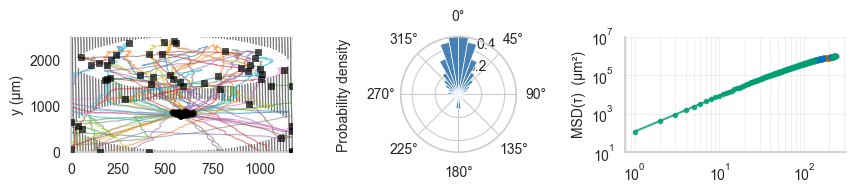

Publication figure saved to: plots/simulation_study_no_chemokine.svg

=== Analysis Summary ===
Mean turning angle: 0.1°
Turning angle std: 39.6°
Directional persistence (R): 0.788


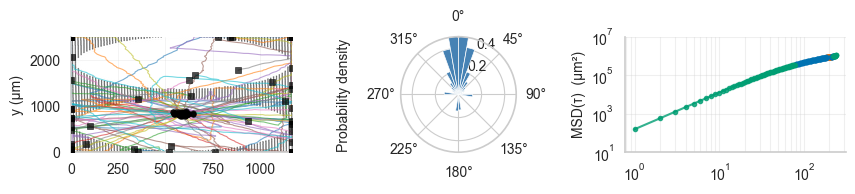

Publication figure saved to: plots/simulation_study_no_persistence.svg

=== Analysis Summary ===
Mean turning angle: 0.8°
Turning angle std: 81.4°
Directional persistence (R): 0.364


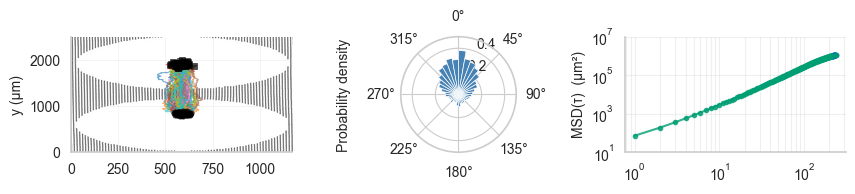

Publication figure saved to: plots/simulation_study_pulsing_chemokine.svg

=== Analysis Summary ===
Mean turning angle: 1.5°
Turning angle std: 74.9°
Directional persistence (R): 0.426


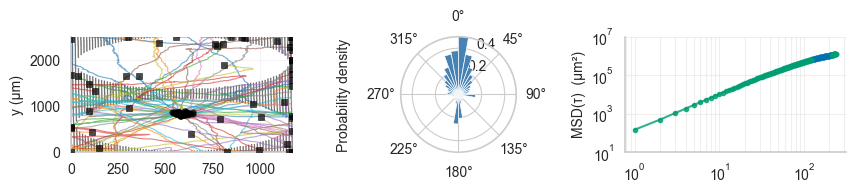

In [5]:
# # # Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'legend.frameon': False,
    #'figure.dpi': 300,
    #'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.transparent': False
})


# ────────────────────────────────
#  Core mathematical functions
# ────────────────────────────────

def msd_with_sem(trajs):
    """
    Calculate MSD with standard error of the mean.

    Parameters:
        trajs : array (n_cells, T, 2)

    Returns:
        msd_mean : array (T,) - mean MSD
        msd_sem : array (T,) - standard error of mean
        lags : array (T,) - lag times
    """
    n_cells, T = trajs.shape[:2]
    lags = np.arange(T)

    msd_individual = compute_MSD_lags(trajs)
    msd_mean = np.mean(msd_individual, axis=0)
    msd_sem = np.std(msd_individual, axis=0) / np.sqrt(n_cells)
    return msd_mean, msd_sem, lags


def fit_power_law(x, y, x_range=None):
    """
    Fit power law: y = A * x^α

    Returns:
        alpha : float - power law exponent
        A : float - prefactor
        r_squared : float - goodness of fit
    """
    if x_range is not None:
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x_fit, y_fit = x[mask], y[mask]
    else:
        x_fit, y_fit = x, y

    # Remove zeros and invalid values
    valid = (x_fit > 0) & (y_fit > 0) & np.isfinite(x_fit) & np.isfinite(y_fit)
    x_fit, y_fit = x_fit[valid], y_fit[valid]

    if len(x_fit) < 2:
        return np.nan, np.nan, np.nan

    # Log-linear fit
    log_x, log_y = np.log10(x_fit), np.log10(y_fit)
    coeffs = np.polyfit(log_x, log_y, 1)
    alpha, log_A = coeffs[0], coeffs[1]
    A = 10**log_A

    # Calculate R²
    y_pred = A * x_fit**alpha
    ss_res = np.sum((y_fit - y_pred)**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return alpha, A, r_squared


def calculate_directional_stats(angles):
    """Calculate circular statistics for turning angles."""
    if len(angles) == 0:
        return {'mean': np.nan, 'std': np.nan, 'concentration': np.nan}

    mean_angle = circmean(angles)
    std_angle = circstd(angles)

    # Calculate concentration parameter (inverse of circular variance)
    R = np.abs(np.mean(np.exp(1j * angles)))
    concentration = R / (1 - R) if R < 1 else np.inf

    return {
        'mean': mean_angle,
        'std': std_angle,
        'concentration': concentration,
        'mean_resultant_length': R
    }


# ────────────────────────────────────────────────────────────────────
# main plotting routine
# ────────────────────────────────────────────────────────────────────
def plot_trajectory_overlay(
        ax, trajs, *, n_show=50, alpha=0.6, colormap='tab10',
        show_start_end=True, scale_bar=None, show_image=True,
        x_min=None, x_max=None, y_min=None, y_max=None,
        img_path='Cell_migration_grid_v3_final2_invers.tiff', plot_legend=True):
    """
    Overlay trajectories with start/end markers and a *cropped & scaled*
    background image that never alters the data limits.

    Parameters are identical to your earlier version.
    """
    # ─────────────── trajectories & markers ────────────────
    n_show = min(n_show, len(trajs))
    cmap   = plt.colormaps.get_cmap(colormap)
    colours = cmap(np.linspace(0, 1, n_show))

    for i, tr in enumerate(trajs[:n_show]):
        ax.plot(tr[:, 0], tr[:, 1],
                color=colours[i], lw=0.8, alpha=alpha, zorder=2)

        handles = []
        if show_start_end:
            h = ax.scatter(*tr[0],  c='black', alpha=0.7, s=15,  marker='o', lw=0.5, zorder=3, label='Start')
            handles.append(h)
            h = ax.scatter(*tr[-1], c='black', alpha=0.7, s=15, marker='s', lw=0.5, zorder=3, label='End of trajectory')
            handles.append(h)

    # ─────────────── background image (cropped) ────────────────
    if x_min is None:
        x_min, x_max = ax.get_xlim()
    if y_min is None:
        y_min, y_max = ax.get_ylim()
    if show_image and Path(img_path).exists():
        # read image so its aspect matches the data window
        img = plt.imread(img_path)
        ax.imshow(img,
                  origin='lower',
                  #extent=[x_min, x_max, y_min, y_max],
                  aspect='auto',          # preserve pixel squares
                  zorder=0,
                  interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp

    # apply limits so nothing moves
    #ax.set_xlim(x_min, x_max)
    #ax.set_ylim(y_min, y_max)

    # ─────────────── cosmetics ────────────────
    if len(handles) > 0 and plot_legend:
        ax.legend(handles=handles, loc='lower center', ncols=2, bbox_to_anchor=(0.5, -0.7))

    if scale_bar is not None:
        add_scale_bar(ax, scale_bar)   # your own helper

    ax.set_aspect('auto', adjustable='box')
    #ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.grid(True, alpha=0.3, lw=0.5)


def plot_polar_rose(ax, angles, bins=36, show_arrow=False, color='steelblue'):
    """Enhanced polar histogram with statistical annotations."""
    if len(angles) == 0:
        ax.text(0.5, 0.5, 'No valid angles', transform=ax.transAxes,
                ha='center', va='center')
        return

    # Create histogram
    counts, bin_edges = np.histogram(angles, bins=bins, range=(-np.pi, np.pi))
    widths = np.diff(bin_edges)
    centers = bin_edges[:-1] + widths/2

    # Normalize counts to probability density
    density = counts / (np.sum(counts) * widths)

    # Plot bars
    ax.bar(centers, density, width=widths, bottom=0.0,
                  align='center', alpha=1, color=color, edgecolor='white', linewidth=0.5)

    # Calculate and display statistics
    if show_arrow:
        stats = calculate_directional_stats(angles)

        # Add mean direction arrow
        if not np.isnan(stats['mean']):
            max_density = np.max(density)
            if max_density > 0.3:
                ax.arrow(stats['mean'], 0, 0, max_density * 0.8,
                        head_width=0.1, head_length=max_density*0.1,
                        fc='red', ec='red', linewidth=2, alpha=0.8, zorder=5)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 0.5) #np.max(density) * 1.1)
    #ax.set_xlabel('Turning angle')
    ax.text(-0.55, 0.5, 'Probability density', transform=ax.transAxes,
                horizontalalignment='left',  # Align text to the left
                verticalalignment='center',  # Align text to the top
                rotation=90)

    # Add angle labels
    ax.set_thetagrids(np.arange(0, 360, 45),
                     labels=['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])


def plot_msd_analysis(ax, trajs, colour_by_regime=True, plot_legend=True):
    """
    MSD ± SEM on log–log axes, optional power-law fits, and (if
    colour_by_regime=True) the MSD line segments are coloured according
    to the local log-slope:
        • red   → sub-diffusive   (α < 0.8)
        • green → diffusive       (0.8 ≤ α ≤ 1.2)
        • blue  → super-diffusive (α > 1.2)
    """
    # ------------------------------------------------------------------
    # 1. ensemble MSD and SEM
    # ------------------------------------------------------------------
    msd_mean, msd_sem, lags = msd_with_sem(trajs)          # your helper
    tau           = lags[1:]                               # skip τ = 0
    msd_vals      = msd_mean[1:]
    msd_errors    = msd_sem[1:]

    # ------------------------------------------------------------------
    # 2. regime colouring (optional)
    # ------------------------------------------------------------------
    if colour_by_regime:
        # log-space derivatives
        log_tau = np.log10(tau)
        log_msd = np.log10(msd_vals)
        slopes  = np.gradient(log_msd, log_tau)

        # masks for each regime
        masks   = {
            'sub'  : slopes < 0.75,
            'diff' : (slopes >= 0.75) & (slopes <= 1.25),
            'super': slopes > 1.25
        }
        colours = {'sub': '#D55E00', 'diff': '#0072B2', 'super': '#009E73'}
        #labels  = {'sub':  r'Sub-diff.  (α<0.8)',
        #           'diff': r'Diffusive (0.8≤α≤1.2)',
        #           'super':r'Super-diff. (α>1.2)'}
        labels  = {'sub':  r'Sub-diff.',
                   'diff': r'Diffusive',
                   'super':r'Super-diff.'}
        # make sure all labels are shown
        for key, label in labels.items():
            if label is not None:
                ax.errorbar([], [], yerr=[], color=colours[key], lw=2, label=label)

        # plot separate line segments, one per regime
        for key, mask in masks.items():
            if not np.any(mask):
                continue
            # break into contiguous runs
            idx     = np.where(mask)[0]
            splits  = np.where(np.diff(idx) > 1)[0] + 1
            chunks  = np.split(idx, splits)

            for chunk in chunks:
                ax.errorbar(tau[chunk], msd_vals[chunk],
                            yerr=msd_errors[chunk],
                            color=colours[key],
                            marker='o', ms=3, alpha=0.8)

    else:
        # single-colour MSD
        ax.errorbar(tau, msd_vals, yerr=msd_errors,
                    color='navy', marker='o', ms=3, alpha=0.8, label='MSD ± SEM')

    # ------------------------------------------------------------------
    # 3. log–log axes & cosmetics
    # ------------------------------------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel('Lag time τ (time steps)')
    ax.set_ylabel('MSD(τ)  (μm²)')
    ax.grid(True, which='both', alpha=0.3)
    ax.set_ylim(10, 1e7)
    if plot_legend:
        ax.legend(loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.7))


def add_scale_bar(ax, length, units='μm', loc='lower right'):
    """Add a scale bar to the plot."""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if loc == 'lower right':
        x = xlim[1] - (xlim[1] - xlim[0]) * 0.15
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1
    else:
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1

    ax.plot([x-length, x], [y, y], 'k-', linewidth=3)
    ax.text(x-length/2, y + (ylim[1]-ylim[0])*0.02, f'{length} {units}',
            ha='center', va='bottom', fontsize=8)


# ────────────────────────────────
#  Master plotting function
# ────────────────────────────────
def create_publication_figure(trajs,
                             save_path='cell_motion_analysis.pdf',
                             figure_size=(10, 1.5),
                             n_trajectories=50,
                             rose_bins=36,
                             scale_bar_length=None,
                             show_image=True,
                             plot_legend=False):
    """
    Create publication-quality figure with enhanced visualizations.

    Parameters:
        trajs : array (n_cells, T, 2) - trajectory data
        save_path : str - output file path
        figure_size : tuple - figure dimensions in inches
        n_trajectories : int - number of trajectories to show in overlay
        rose_bins : int - number of bins for polar histogram
        scale_bar_length : float - length of scale bar in micrometers
        show_image : bool - whether to show background image
        plot_legend : bool - whether to plot legend
    """
    # Calculate turning angles for all trajectories
    all_angles = []
    for traj in trajs:
        angles = turning_angle({'x': traj[:, 0], 'y': traj[:, 1]})
        if len(angles) > 0:
            all_angles.extend(angles)
    all_angles = np.array(all_angles)

    # Create figure with custom layout
    fig = plt.figure(figsize=figure_size)
    gs = GridSpec(1, 3, figure=fig, width_ratios=[0.33, 0.33, 0.33], wspace=0.25)

    # Panel A: Trajectory overlay
    ax1 = fig.add_subplot(gs[0, 0])
    x_min, x_max = 500, 650
    y_min, y_max = 600, 2100
    plot_trajectory_overlay(ax1, trajs, n_show=n_trajectories,
                            x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
                           scale_bar=scale_bar_length, show_image=show_image, plot_legend=plot_legend)

    # Panel B: Turning angle distribution
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    plot_polar_rose(ax2, all_angles, bins=rose_bins)

    # Panel C: MSD analysis
    ax3 = fig.add_subplot(gs[0, 2])
    plot_msd_analysis(ax3, trajs, plot_legend=plot_legend)

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'Publication figure saved to: {save_path}')

    if len(all_angles) > 0:
        # Print summary statistics
        print(f"\n=== Analysis Summary ===")
        stats = calculate_directional_stats(all_angles)
        print(f"Mean turning angle: {np.degrees(stats['mean']):.1f}°")
        print(f"Turning angle std: {np.degrees(stats['std']):.1f}°")
        print(f"Directional persistence (R): {stats['mean_resultant_length']:.3f}")

    return fig


for model_name, sim_data in models_simulations.items():
    fig = create_publication_figure(
        sim_data['sim'][:, :240],
        save_path=f'plots/simulation_study_{model_name}.svg',
        n_trajectories=50,
        show_image=True,
        #plot_legend=True if model_name == 'classic' else False
    )
    plt.show()